# **Project Drones**

### Inladen van de libraries

In [1]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

### Inladen van data

(3609, 600, 600, 3)

(174, 600, 600, 3)

(350, 600, 600, 3)

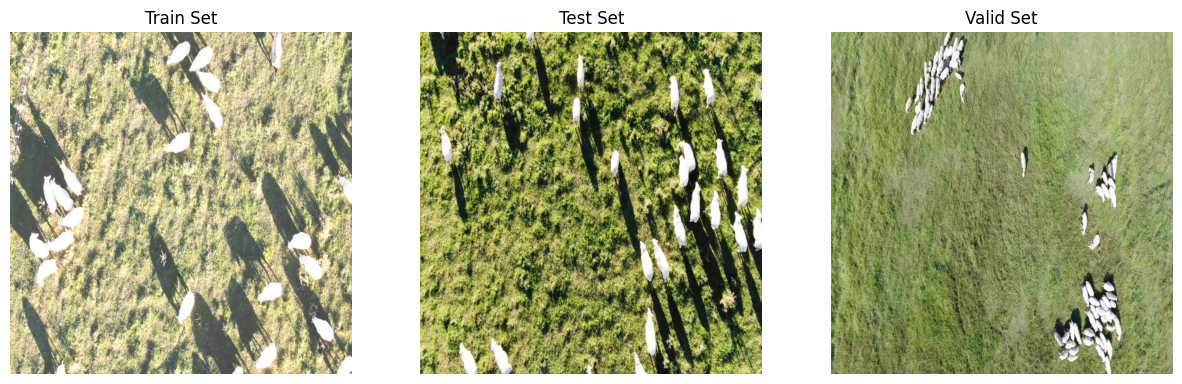

In [2]:
def laad_afbeeldingen(map_pad):
    afbeeldingen = []
    bestandsnamen = os.listdir(map_pad)

    for bestandsnaam in bestandsnamen:
        afbeelding_pad = os.path.join(map_pad, bestandsnaam)
        if os.path.isfile(afbeelding_pad):
            afbeelding = Image.open(afbeelding_pad)
            afbeeldingen.append(np.array(afbeelding))

    return np.array(afbeeldingen)

def toon_willekeurige_afbeeldingen_per_set(train_afbeeldingen, test_afbeeldingen, valid_afbeeldingen):
    train_afbeelding = train_afbeeldingen[np.random.randint(len(train_afbeeldingen))]
    test_afbeelding = test_afbeeldingen[np.random.randint(len(test_afbeeldingen))]
    valid_afbeelding = valid_afbeeldingen[np.random.randint(len(valid_afbeeldingen))]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(train_afbeelding)
    axs[0].set_title("Train Set")
    axs[0].axis('off')
    axs[1].imshow(test_afbeelding)
    axs[1].set_title("Test Set")
    axs[1].axis('off')
    axs[2].imshow(valid_afbeelding)
    axs[2].set_title("Valid Set")
    axs[2].axis('off')
    plt.show()

train_map_pad = 'train'
train_afbeeldingen = laad_afbeeldingen(train_map_pad)

test_map_pad = 'test'
test_afbeeldingen = laad_afbeeldingen(test_map_pad)

valid_map_pad = 'valid'
valid_afbeeldingen = laad_afbeeldingen(valid_map_pad)

display(train_afbeeldingen.shape, test_afbeeldingen.shape, valid_afbeeldingen.shape)
toon_willekeurige_afbeeldingen_per_set(train_afbeeldingen, test_afbeeldingen, valid_afbeeldingen)

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/Users/vince/DatalabIV/Datalab-IV


In [2]:
#!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.9.6 torch-2.2.1 CPU (Apple M3 Pro)
Setup complete ✅ (11 CPUs, 18.0 GB RAM, 312.0/460.4 GB disk)


In [3]:
from ultralytics import YOLO
from IPython.display import display, Image

In [5]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

#!pip install roboflow --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="fO4Sr4BbAbY8QjHxMyuz")
project = rf.workspace("riis").project("aerial-sheep")
version = project.version(1)
dataset = version.download("yolov8")

mkdir: /Users/vince/DatalabIV/Datalab-IV/datasets: File exists
/Users/vince/DatalabIV/Datalab-IV/datasets
loading Roboflow workspace...
loading Roboflow project...


In [10]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8n.pt data={dataset.location}/data.yaml epochs=1 imgsz=800

/Users/vince/DatalabIV/Datalab-IV
100%|██████████████████████████████████████| 6.23M/6.23M [00:03<00:00, 1.80MB/s]
New https://pypi.org/project/ultralytics/8.1.27 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.9.6 torch-2.2.1 CPU (Apple M3 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/vince/DatalabIV/Datalab-IV/datasets/Aerial-Sheep-1/data.yaml, epochs=1, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, 

In [13]:
import subprocess
import os

# Verkrijg de locatie van de thuismap
home = os.path.expanduser("~")

# Definieer de locatie van de dataset
dataset_location = '/Users/vince/DatalabIV/Datalab-IV/datasets/Aerial-Sheep-1'

# Bouw het shell-commando op
command = f"yolo task=detect mode=train model=yolov8n.pt data={dataset_location}/data.yaml epochs=1 imgsz=800"

# Verander de huidige werkmap naar de thuismap
os.chdir(home)

# Voer het shell-commando uit
subprocess.run(command, shell=True)

New https://pypi.org/project/ultralytics/8.1.27 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.9.6 torch-2.2.1 CPU (Apple M3 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/vince/DatalabIV/Datalab-IV/datasets/Aerial-Sheep-1/data.yaml, epochs=1, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=Fa

CompletedProcess(args='yolo task=detect mode=train model=yolov8n.pt data=/Users/vince/DatalabIV/Datalab-IV/datasets/Aerial-Sheep-1/data.yaml epochs=1 imgsz=800', returncode=0)